# Energy volume curve
## Theory 
By fitting the energy-volume curve, we can determine several equilibrium properties, including the equilibrium energy $E_0$, equilibrium volume $V_0$, equilibrium bulk modulus $B_0$, and its derivative $B_0'$. These properties are then utilized in the Einstein model to provide an initial estimation for the thermodynamic properties, namely the heat capacity $C_v$ and the free energy $F$.

## Initialisation

We start by importing matplotlib, numpy and the pyiron project class. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyiron import Project
%matplotlib inline 

In the next step we create a project, by specifying its relative path/name.

In [2]:
pr = Project('thermo')

## Atomistic structure

To analyse the energy volume dependence a single super cell is sufficient, so we create an iron super cell as an example.

In [3]:
basis = pr.create.structure.bulk(name='Fe', cubic=True, a=2.85)
basis.plot3d()

NGLWidget()

## Measure energies by looping over different volumes

Let's first see how we can get the energy as a function of the volume mainly based on the knowledge you acquired in the [first tutorial notebook](https://pyiron.readthedocs.io/en/latest/source/notebooks/first_steps.html). For this, we are going to vary the volume of our initial structure by up to 5 %.

Energy volume curves are commonly calculated with ab-initio simulation codes. In this example, we use [GPAW](https://wiki.fysik.dtu.dk/gpaw/), but the functionality below would work just as well with any DFT code, just by changing the job name prefix `Gpaw` to the DFT code of your choice (e.g. `Vasp`, `Sphinx`...). In this tutorial, we select an energy cutoff of 320 eV, but the simulation would run without changing any parameter. For the rest of the DFT parameters, you can look up functions starting with `job.set_*`.

### Launch calculations

In [4]:
# Exponent of 1/3 to translate volume strain of 5 % to line strain
line_strain_list = np.linspace(0.95, 1.05, 7)**(1 / 3) - 1

In [5]:
for strain in line_strain_list:
    dft = pr.create.job.Gpaw(job_name=('sample', strain))
    dft.set_encut(320.0) # Optional, among other plane wave dft parameters
    dft.structure = basis.apply_strain(strain, return_box=True)
    dft.run()

The job sample_m0d01695243 was saved and received the ID: 19694133
The job sample_m0d01123691 was saved and received the ID: 19694134
The job sample_m0d00558671 was saved and received the ID: 19694135
The job sample_0d0 was saved and received the ID: 19694136
The job sample_0d00552497 was saved and received the ID: 19694137
The job sample_0d01098989 was saved and received the ID: 19694138
The job sample_0d01639636 was saved and received the ID: 19694139


If your environment allows you to launch calculations to a queueing system, it might be useful to set

```python
dft.server.queue = "name_of_the_queue"
dft.server.cores = number_of_cores
dft.server.run_time = run_time_in_seconds
```

Queueing system setup can be found in the pyiron docs, the homepage for which is [here](https://pyiron.readthedocs.io/en/latest/index.html)

### Analyse results

In [6]:
results = {'energy': [], 'volume': []}
for strain in line_strain_list:
    dft = pr.load(('sample', strain))
    results['volume'].append(dft.structure.get_volume())
    results['energy'].append(dft.output.energy_pot[-1])

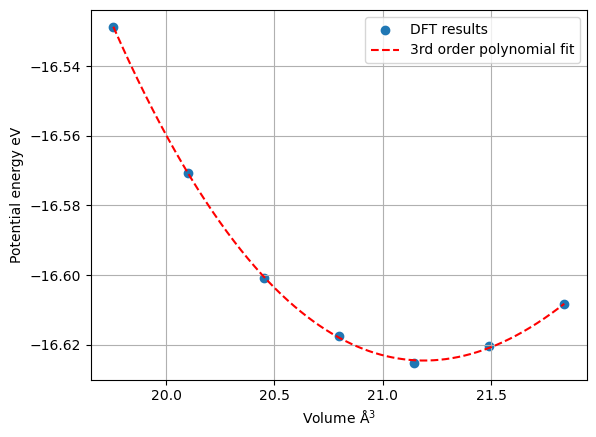

In [7]:
plt.ylabel('Potential energy eV')
plt.xlabel(r'Volume $\mathrm{\AA}^3$')
plt.grid()
plt.scatter(results['volume'], results['energy'], label='DFT results');
coeff = np.polyfit(results['volume'], results['energy'], 3)
volume_mesh = np.linspace(np.min(results['volume']), np.max(results['volume']), 1000)
energy_mesh = np.polyval(coeff, volume_mesh)
plt.plot(volume_mesh, energy_mesh, 'r--', label='3rd order polynomial fit');
plt.legend();

So the results look good enough for us to start extract physical parameters:

In [8]:
equi_volume = np.roots(np.polyder(coeff)).min()
print('Equilibrium volume:', np.round(equi_volume, decimals=3), 'A^3')
equi_bulk_mod = np.polyval(np.polyder(coeff, 2), equi_volume) * equi_volume
print('Equilibrium bulk modulus:', np.round(equi_bulk_mod, decimals=3), 'eV/A^3')

Equilibrium volume: 21.19 A^3
Equilibrium bulk modulus: 1.753 eV/A^3


Translation of eV/A^3 to GPa takes a factor of around 160, meaning the bulk modulus measured here is around 280 GPa, which is comparable to experimental results.

So far, we examined the procedure for conducting an energy-volume curve analysis through the manual creation of jobs. It is great that it requires only around 10 to 20 lines of code, but since it's such a common routine, we also offer the master class `Murnaghan` for this purpose, which offers an array of enhanced functionalities designed to streamline the process.

## Murnaghan Job

In order to launch a set of DFT calculations with varying volumes and do the analysis afterwards, the Murnaghan job can be used.

In [9]:
dft = pr.create.job.Gpaw(job_name='gpaw')
dft.set_encut(320) # Again, optional
dft.structure = basis.copy()
murn = dft.create_job(job_type=pr.job_type.Murnaghan, job_name='murn')
murn.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'mur..."
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume define...
4,axes,"[x, y, z]",Axes along which the strain will be applied
5,strains,None,List of strains that should be calculated. If...


In principle you can run the simulation without touching the input, but since we chose 7 points and volume strain of 5%, let's take these parameters here as well:

In [10]:
murn.input['num_points'] = 7
murn.input['vol_range'] = 0.05

In [11]:
murn.run()

The job murn was saved and received the ID: 19694140
The job murn_0_95 was saved and received the ID: 19694141
The job murn_0_9666667 was saved and received the ID: 19694142
The job murn_0_9833333 was saved and received the ID: 19694143
The job murn_1_0 was saved and received the ID: 19694144
The job murn_1_0166667 was saved and received the ID: 19694145
The job murn_1_0333333 was saved and received the ID: 19694146
The job murn_1_05 was saved and received the ID: 19694147


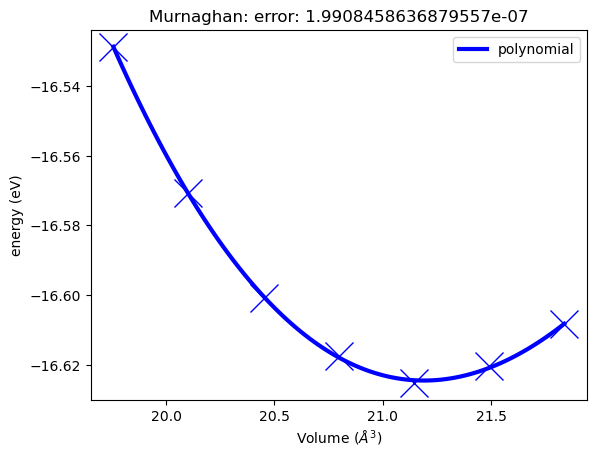

In [12]:
murn.plot();

## Analysis

In the first section of this notebook, we took a look at a polynomial fit (because it's simple!). In pyiron, we offer multiple ways to fit the points: Vinet, Murnaghan, Birch-Murnaghan and polynomial. We show the comparison below:

In [13]:
fit_dict = {
    "Vinet": murn.fit_vinet(),
    "Murnaghan": murn.fit_murnaghan(),
    "Birch-Murnaghan": murn.fit_birch_murnaghan(),
    "Polynomial": murn.fit_polynomial(),
}

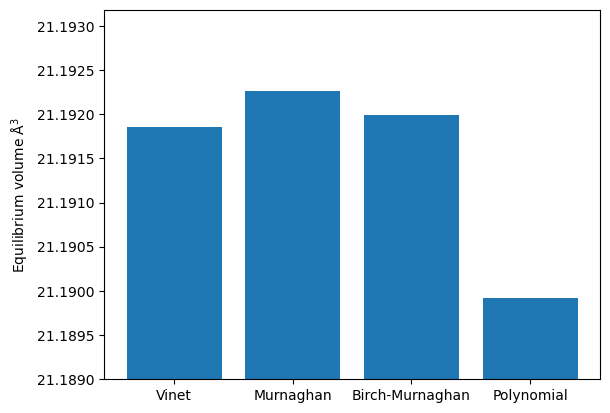

In [14]:
names = list(fit_dict.keys())
volumes = [d["volume_eq"] for d in fit_dict.values()]
plt.ylim([min(volumes) - np.std(volumes), max(volumes) + np.std(volumes)])
plt.ylabel(r"Equilibrium volume $\mathrm{\AA}^3$")
plt.bar(names, volumes);


We can see that the fitting method gives a slight difference in the results. It is important to keep in mind that in DFT calculations the equilibrium volume can easily vary by more than one percent, depending on the type of pseudo-potential used. In this regard, we can consider all of these results to be acceptably correct.

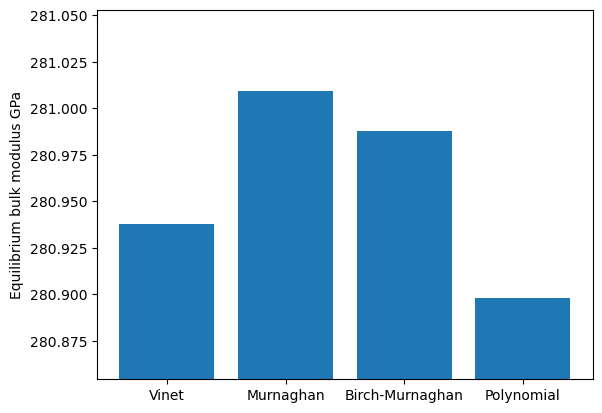

In [15]:
names = list(fit_dict.keys())
volumes = [d["bulkmodul_eq"] for d in fit_dict.values()]
plt.ylim([min(volumes) - np.std(volumes), max(volumes) + np.std(volumes)])
plt.ylabel("Equilibrium bulk modulus GPa")
plt.bar(names, volumes);


## Energy cut-off dependence

We launched the DFT calculations above using the energy cutoff of 320 eV. However, in order to obtain a physically meaningful result, the energy cutoff (among other plane-wave DFT parameters) should be varied to see the convergence of the output values we are interested in. As the energy cutoff refers to the maximum kinetic energy that is allowed for the plane wave basis functions used to describe the electronic wavefunctions, choosing a higher energy cutoff means including more plane waves in the basis set, which can improve the accuracy of the calculations but also increases the computational cost. Conversely, choosing a lower energy cutoff reduces the computational cost but can lead to less accurate results. Therefore, the energy cutoff is an important parameter in plane wave DFT calculations, and it must be carefully chosen to balance accuracy and computational efficiency for a particular system or calculation. Here, we take a look at the partial convergence of the equilibrium volume and bulk modulus. For the sake of quick DFT convergence the energy cutoff is chosen between 270 eV and 320 eV (and not higher), but in the scientific context you should see how far you have to go in order to see a true convergence, which also applies for other plane-wave DFT parameters (e.g. k-point mesh)

In [16]:
encut_lst = np.linspace(270, 320, 6)

In [17]:
volume_lst = []
bulk_modulus_lst = []
for encut in encut_lst:
    dft = pr.create.job.Gpaw(job_name=('dft', encut))
    dft.set_encut(encut)
    dft.structure = basis.copy()
    murn = dft.create_job(job_type=pr.job_type.Murnaghan, job_name=dft.job_name.replace("dft", "murn"))
    murn.input['num_points'] = 7
    murn.input['vol_range'] = 0.05
    murn.run()
    volume_lst.append(murn.fit_vinet()["volume_eq"])
    bulk_modulus_lst.append(murn.fit_vinet()["bulkmodul_eq"])

The job murn_270d0 was saved and received the ID: 19694148
The job murn_270d0_0_95 was saved and received the ID: 19694149
The job murn_270d0_0_9666667 was saved and received the ID: 19694150
The job murn_270d0_0_9833333 was saved and received the ID: 19694151
The job murn_270d0_1_0 was saved and received the ID: 19694152
The job murn_270d0_1_0166667 was saved and received the ID: 19694153
The job murn_270d0_1_0333333 was saved and received the ID: 19694154
The job murn_270d0_1_05 was saved and received the ID: 19694155
The job murn_280d0 was saved and received the ID: 19694156
The job murn_280d0_0_95 was saved and received the ID: 19694157
The job murn_280d0_0_9666667 was saved and received the ID: 19694158
The job murn_280d0_0_9833333 was saved and received the ID: 19694159
The job murn_280d0_1_0 was saved and received the ID: 19694160
The job murn_280d0_1_0166667 was saved and received the ID: 19694161
The job murn_280d0_1_0333333 was saved and received the ID: 19694162
The job murn

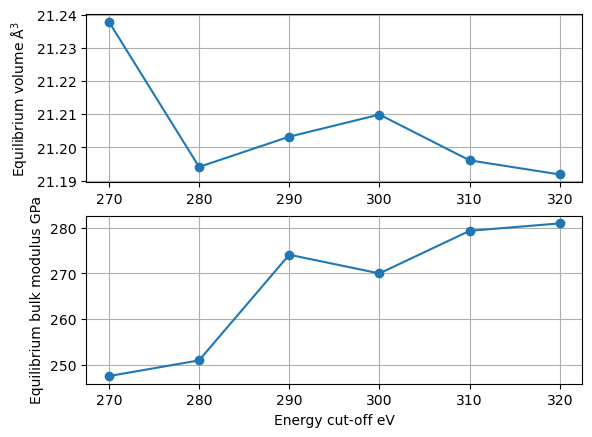

In [18]:
plt.subplot(2, 1, 1)
plt.grid()
plt.ylabel(r"Equilibrium volume $\mathrm{\AA}^3$")
plt.plot(encut_lst, volume_lst, "-o");
plt.subplot(2, 1, 2)
plt.grid()
plt.ylabel("Equilibrium bulk modulus GPa")
plt.xlabel("Energy cut-off eV")
plt.plot(encut_lst, bulk_modulus_lst, "-o");